# 手写识别图像识别前馈网络

本实验主要内容是进行手写字体图像的识别，用到的框架主要包括：MindSpore0.5.0，主要用于深度学习算法的构建，本实验以开源的手写字体数据集为基础，基于MindSpore深度学习库对手写字体进行识别。


## 导入实验环境

In [1]:
#导入相关依赖库
import  os
# os.environ['DEVICE_ID'] = '7'

from matplotlib import pyplot as plt
import numpy as np

import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy

from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')

## 导入实验数据集

In [2]:
ds_train = ds.MnistDataset(os.path.join(r'./MNIST', "train"))
ds_test = ds.MnistDataset(os.path.join(r'./MNIST', "test")) 

print('训练数据集数量：',ds_train.get_dataset_size())
print('测试数据集数量：',ds_test.get_dataset_size())
image=ds_train.create_dict_iterator().__next__()
print('图像长/宽/通道数：',image['image'].shape)
print('一张图像的标签样式：',image['label'])    #一共10类，用0-9的数字表达类别。


训练数据集数量： 60000
测试数据集数量： 10000
图像长/宽/通道数： (28, 28, 1)
一张图像的标签样式： 7


In [3]:
DATA_DIR_TRAIN = "MNIST/train" # 训练集信息
DATA_DIR_TEST = "MNIST/test" # 测试集信息

def create_dataset(training=True, batch_size=128, resize=(28, 28),
                   rescale=1/(255*0.3081), shift=-0.1307/0.3081, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    
    # define map operations
    resize_op = CV.Resize(resize)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    
    # apply map operations on images
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
#     ds = ds.repeat(num_epoch)
    
    return ds

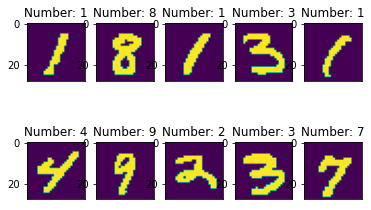

In [4]:
#显示前10张图片以及对应标签,检查图片是否是正确的数据集
ds = create_dataset(training=False)
data = ds.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()

for i in range(1,11):
    plt.subplot(2, 5, i)
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()

## 手写字体图像识别建模

数据集准备完成，接下来我们就需要构建训练模型，我们首先需要建立初始化的神经网络。

In [5]:
#创建模型。模型包括5个卷积层和RELU激活函数，一个全连接输出层并使用softmax进行多分类，共分成（0-9）10类
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(784, 512, activation='relu')
        self.fc2 = nn.Dense(512, 256, activation='relu')
        self.fc3 = nn.Dense(256, 128, activation='relu')
        self.fc4 = nn.Dense(128, 64, activation='relu')
        self.fc5 = nn.Dense(64, 32, activation='relu')
        self.fc6 = nn.Dense(32, 10, activation='softmax')
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)   
        output = self.fc4(output)
        output = self.fc5(output)
        output = self.fc6(output)
        return output 

In [6]:
#创建网络，损失函数，评估指标  优化器
lr = 0.001
num_epoch = 10
momentum = 0.9

net = ForwardNN()
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
metrics={"Accuracy": Accuracy()}
opt = nn.Adam(net.trainable_params(), lr)

In [7]:
ds_eval = create_dataset(False, batch_size=32)
model = Model(net, loss, opt, metrics)
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)

#训练模型
ds_train = create_dataset(batch_size=32)
print("============== Starting Training ==============")
model.train(num_epoch, ds_train,callbacks=[LossMonitor()],dataset_sink_mode=True)

============== Starting Training ==============
epoch: 1 step: 1875, loss is 1.5270265
epoch: 2 step: 1875, loss is 1.5560682
epoch: 3 step: 1875, loss is 1.4910114
epoch: 4 step: 1875, loss is 1.4923987
epoch: 5 step: 1875, loss is 1.5842149
epoch: 6 step: 1875, loss is 1.6798363
epoch: 7 step: 1875, loss is 1.6174003
epoch: 8 step: 1875, loss is 1.6174002
epoch: 9 step: 1875, loss is 1.4924002
epoch: 10 step: 1875, loss is 1.7736466


In [8]:
#使用测试集评估模型，打印总体准确率
metrics=model.eval(ds_eval)
loss_cb = LossMonitor(per_print_times=1)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
print(metrics)

{'Accuracy': 0.8278245192307693}
